In [49]:
# lib imports
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import torch
import torchaudio
import numpy as np
import os
import sys
import skimage
import skimage.io
from pathlib import Path
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [50]:
# set paths to data
DIR_TRAIN = 'data/train'
DIR_VALID = 'data/valid'

# isolate labels
labels = ['murmur', 'extra', 'normal', 'artifact']

In [51]:
# retrieve training data
# initialize variables
x_out = []
Xdb_out = []
sr_out = []
label_out = []

# loop through data sets to retrieve relevant data
for i in labels:
    base_path = Path(DIR_TRAIN, i)
    for _ in os.listdir(base_path):
        # ignore ds_store
        if _ == '.DS_Store':
            continue
        # use librosa to extract audio features
        x, sr = librosa.load(Path(base_path, _))
        Xdb = librosa.amplitude_to_db(abs(librosa.stft(x)), ref=np.max)

        # save training data
        x_out.append(x)
        Xdb_out.append(Xdb)
        sr_out.append(sr)
        label_out.append(i)

In [45]:
# retrieve validation data
# initialize variables
x_valid = []
Xdb_valid = []
sr_valid = []
label_valid = []

# loop through data sets to retrieve relevant data
for i in labels:
    base_path = Path(DIR_VALID, i)
    for _ in os.listdir(base_path):
        # ignore ds_store
        if _ == '.DS_Store':
            continue
        # use librosa to extract audio features
        x, sr = librosa.load(Path(base_path, _))
        Xdb = librosa.amplitude_to_db(abs(librosa.stft(x)))
  
        # save validation data
        x_valid.append(x)
        Xdb_valid.append(Xdb)
        sr_valid.append(sr)
        label_valid.append(i)

In [46]:
# function setting
# define function to standardize image space
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

# define function to add padding to smaller audio files
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):

    pad_size = target_length - array.shape[axis]

    if pad_size <= 0:
        return array

    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)

    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

# sources : https://stackoverflow.com/questions/19349410/how-to-pad-with-zeros-a-tensor-along-some-axis-python

In [47]:
# retrive maximum allowable matrix lengths
# initialize variables
max_len = []
max_len_chrom = []

# loop through training set
for i in range(len(Xdb_out)):
    # retrieve matrix length in desired direction
    max_len.append(Xdb_out[i].shape[0])
    # retrieve matrix length of chroma shift
    chr = librosa.feature.chroma_stft(x_out[i], sr=sr_out[i], hop_length=100)
    max_len_chrom.append(chr.shape[1])
    
# loop through validation set
for i in range(len(Xdb_valid)):
    # retrieve matrix length in desired direction
    max_len.append(Xdb_valid[i].shape[1])
    # retrieve matrix length of chroma shift
    chr = librosa.feature.chroma_stft(x_valid[i], sr=sr_valid[i], hop_length=100)
    max_len_chrom.append(chr.shape[1])

# extract max matrix lenghts in all data
max_len_final = max(max_len)
max_len_chrom_final = max(max_len_chrom)

In [ ]:
# extract png files for training audio files
# three png's per file
for i in range(len(Xdb_out)):
    # librosa (spectrogram) train
    padded_Xdb = (pad_along_axis(spec_to_image(Xdb_out[i]), max_len_final, axis = 1))
    # save spectrogram image
    fig = plt.Figure()
    canvas1 = FigureCanvas(fig)
    ax1 = fig.add_subplot(111)
    p1 = librosa.display.specshow(padded_Xdb, sr=sr_out[i],ax=ax1)
    fig.savefig(f'./data_librosa_png/train/{label_out[i]}/{i}.png')
    
    
    # chromagram train
    chromagram = librosa.feature.chroma_stft(x_out[i], sr=sr_out[i], hop_length=100)
    padded_chrom = (pad_along_axis(spec_to_image(chromagram), max_len_chrom_final, axis = 1))
    # save chromagram image
    fig = plt.Figure()
    canvas2 = FigureCanvas(fig)
    ax2 = fig.add_subplot(111)
    p2 = librosa.display.specshow(padded_chrom, hop_length=100, ax=ax2, cmap='coolwarm')
    fig.savefig(f'./data_chroma_png/train/{label_out[i]}/{i}.png')
    
    
    # mel-frequency cepstral coefficients train
    mfcc = librosa.feature.mfcc(x_out[i], sr=sr_out[i])
    padded_mfcc = (pad_along_axis(spec_to_image(mfcc), max_len_final, axis = 1))
    # save mfcc image
    fig = plt.Figure()
    canvas3 = FigureCanvas(fig)
    ax3 = fig.add_subplot(111)
    p3 = librosa.display.specshow(padded_mfcc, sr=sr_out[i], ax=ax3)
    fig.savefig(f'./data_mfcc_png/train/{label_out[i]}/{i}.png') 

In [ ]:
# extract png files for validation audio files
# three png's per file
for i in range(len(Xdb_valid)):
    # librosa validation
    padded_Xdb_valid = (pad_along_axis(spec_to_image(Xdb_valid[i]), max_len_final, axis = 1))
    # save spectrogram image
    fig1 = plt.Figure()
    canvas1 = FigureCanvas(fig1)
    ax1 = fig1.add_subplot(111)
    p1 = librosa.display.specshow(padded_Xdb_valid, sr=sr_valid[i],ax=ax1)
    fig1.savefig(f'./data_librosa_png/valid/{label_valid[i]}/{i}.png')
    
    
    # chromagram valid
    chromagram = librosa.feature.chroma_stft(x_valid[i], sr=sr_valid[i], hop_length=100)
    padded_chrom = (pad_along_axis(spec_to_image(chromagram), max_len_chrom_final, axis = 1))
    # save chromagram image
    fig2 = plt.Figure()
    canvas2 = FigureCanvas(fig2)
    ax2 = fig2.add_subplot(111)
    p2 = librosa.display.specshow(padded_chrom, hop_length=100, ax=ax2, cmap='coolwarm')
    fig2.savefig(f'./data_chroma_png/valid/{label_valid[i]}/{i}.png')
    
    
    # mel-frequency cepstral coefficients valid
    mfcc = librosa.feature.mfcc(x_valid[i], sr=sr_valid[i])
    padded_mfcc = (pad_along_axis(spec_to_image(mfcc), max_len_final, axis = 1))
    # save mfcc image
    fig3 = plt.Figure()
    canvas3 = FigureCanvas(fig3)
    ax3 = fig3.add_subplot(111)
    p3 = librosa.display.specshow(padded_mfcc, sr=sr_valid[i], ax=ax3)
    fig3.savefig(f'./data_mfcc_png/valid/{label_valid[i]}/{i}.png')
    

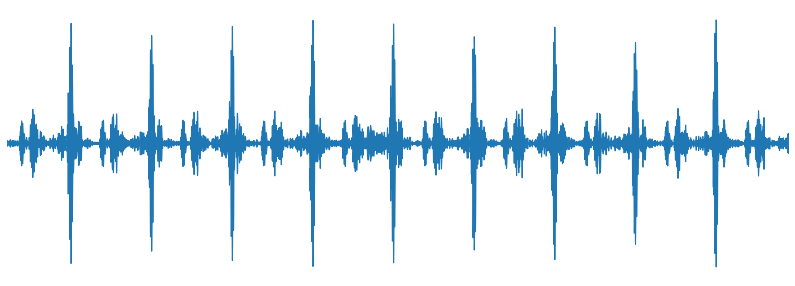

In [122]:
# plotting for presentation slides
plt.figure(figsize=(14, 5))
plt.axis('off')
plt.xlim(0, 0.001) 
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
librosa.display.waveplot(x_out[9], sr=sr_out[9])

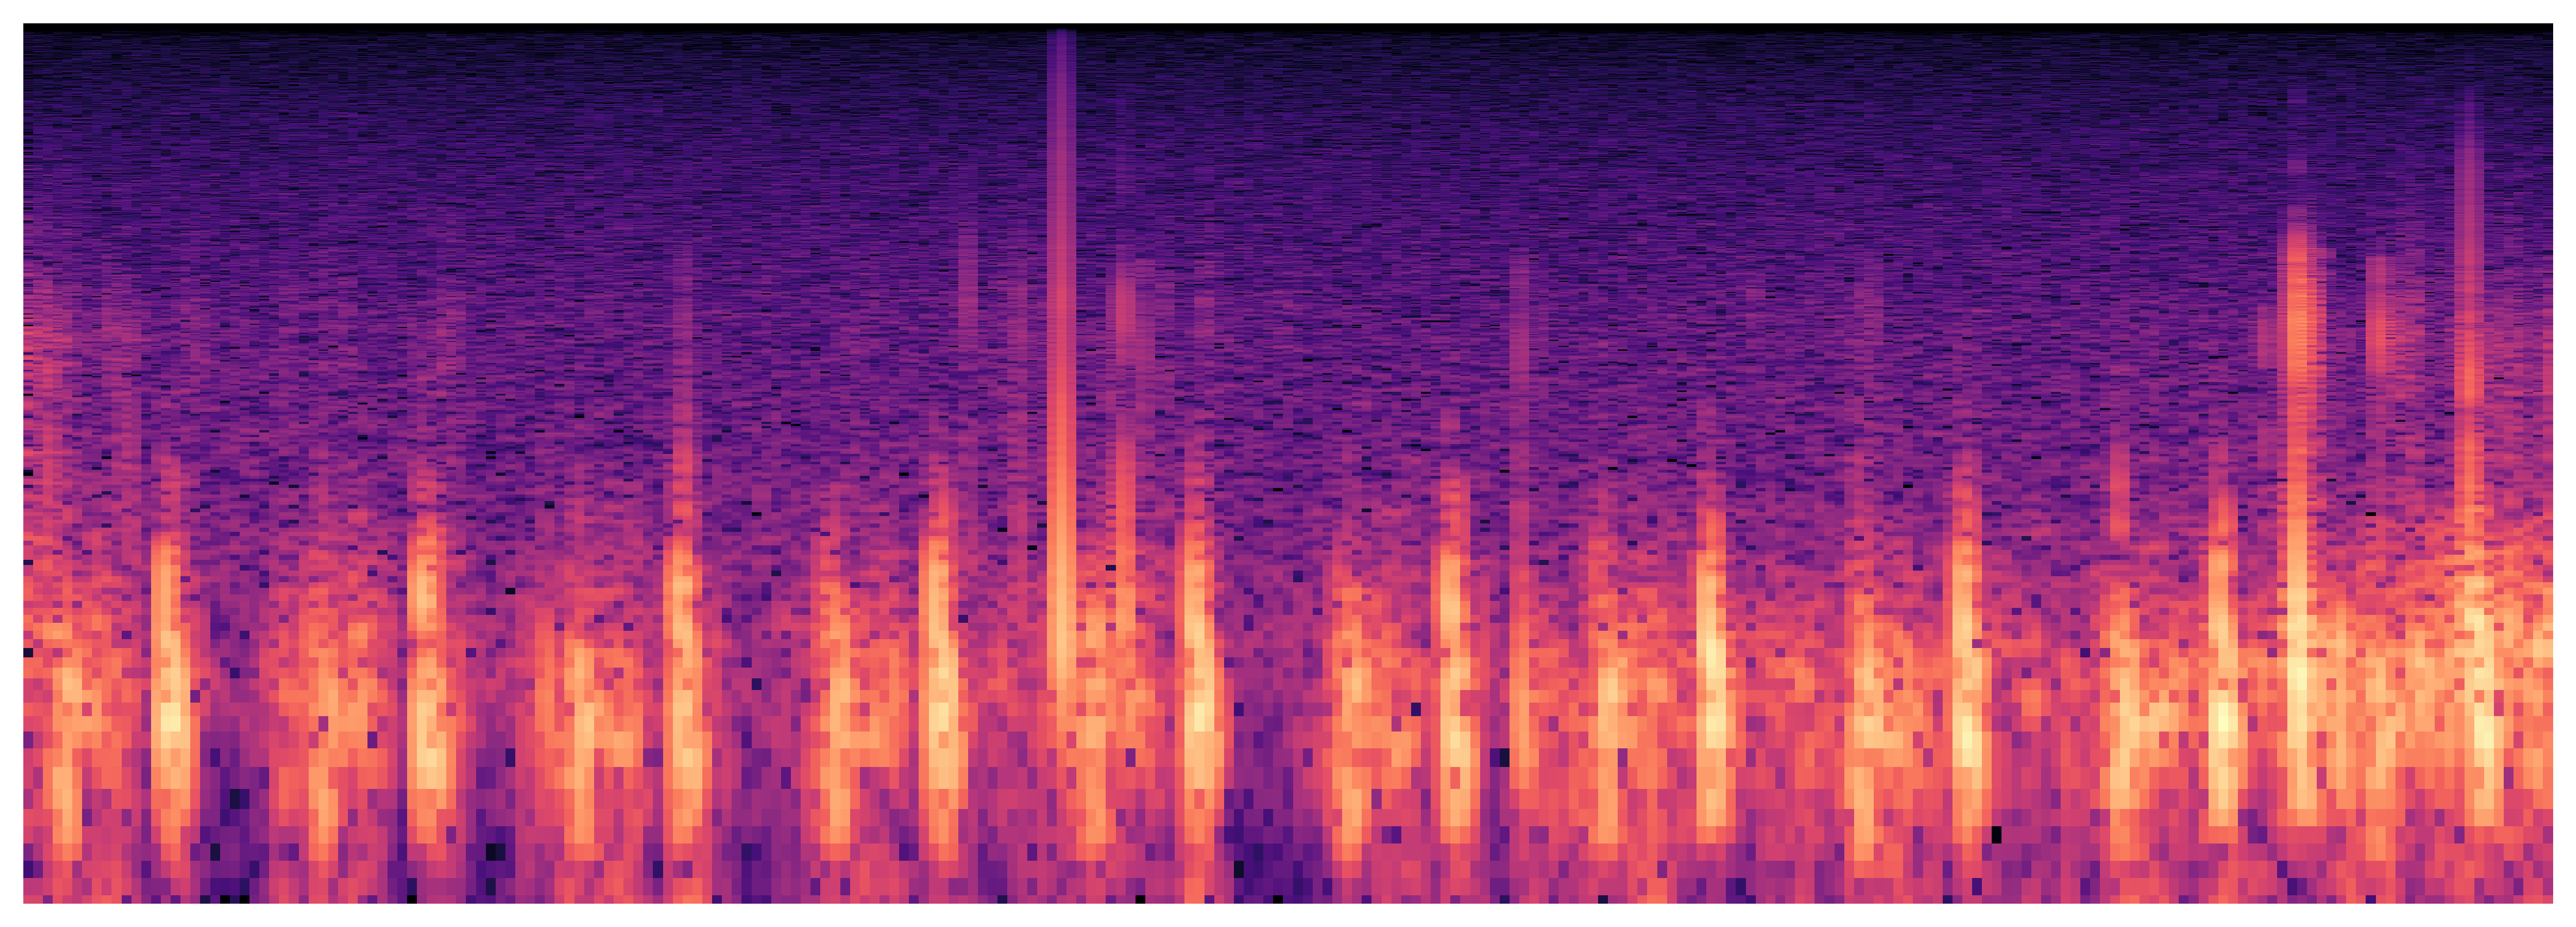

In [119]:
plt.figure(figsize=(14, 5), dpi = 500)
plt.axis('off')
librosa.display.specshow(Xdb_out[11], sr=sr_out[11], x_axis='time', y_axis='log')

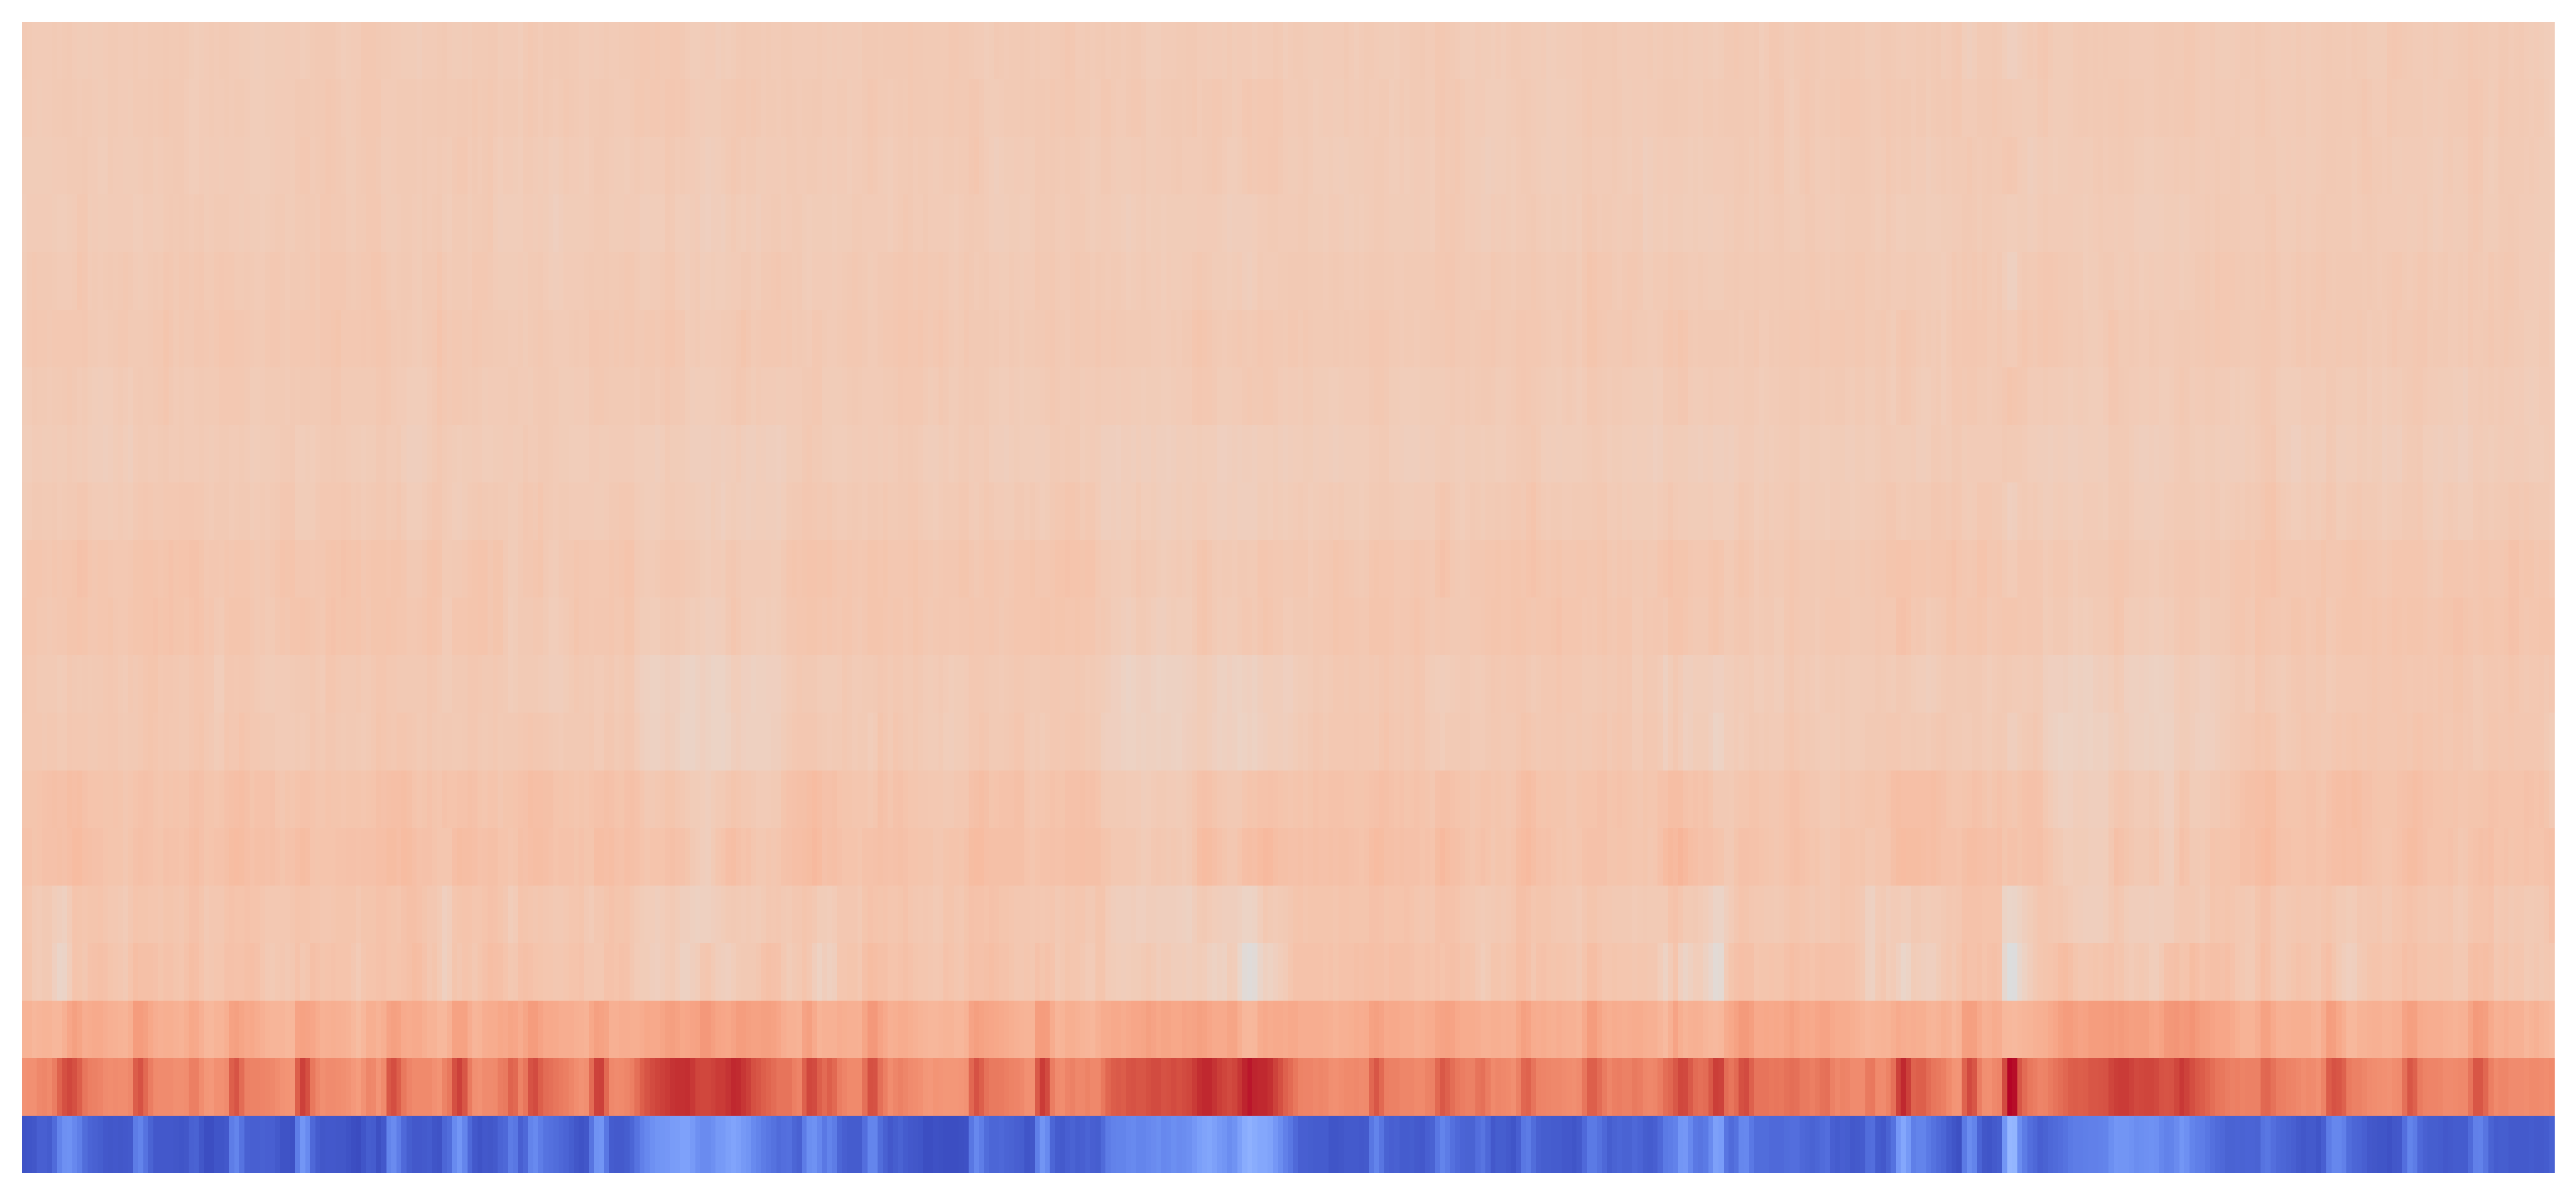

In [120]:
mfccs = librosa.feature.mfcc(x_out[54], sr=sr_out[54])
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7), dpi = 500)
plt.axis('off')
librosa.display.specshow(mfccs, sr=sr_out[54], x_axis='time');

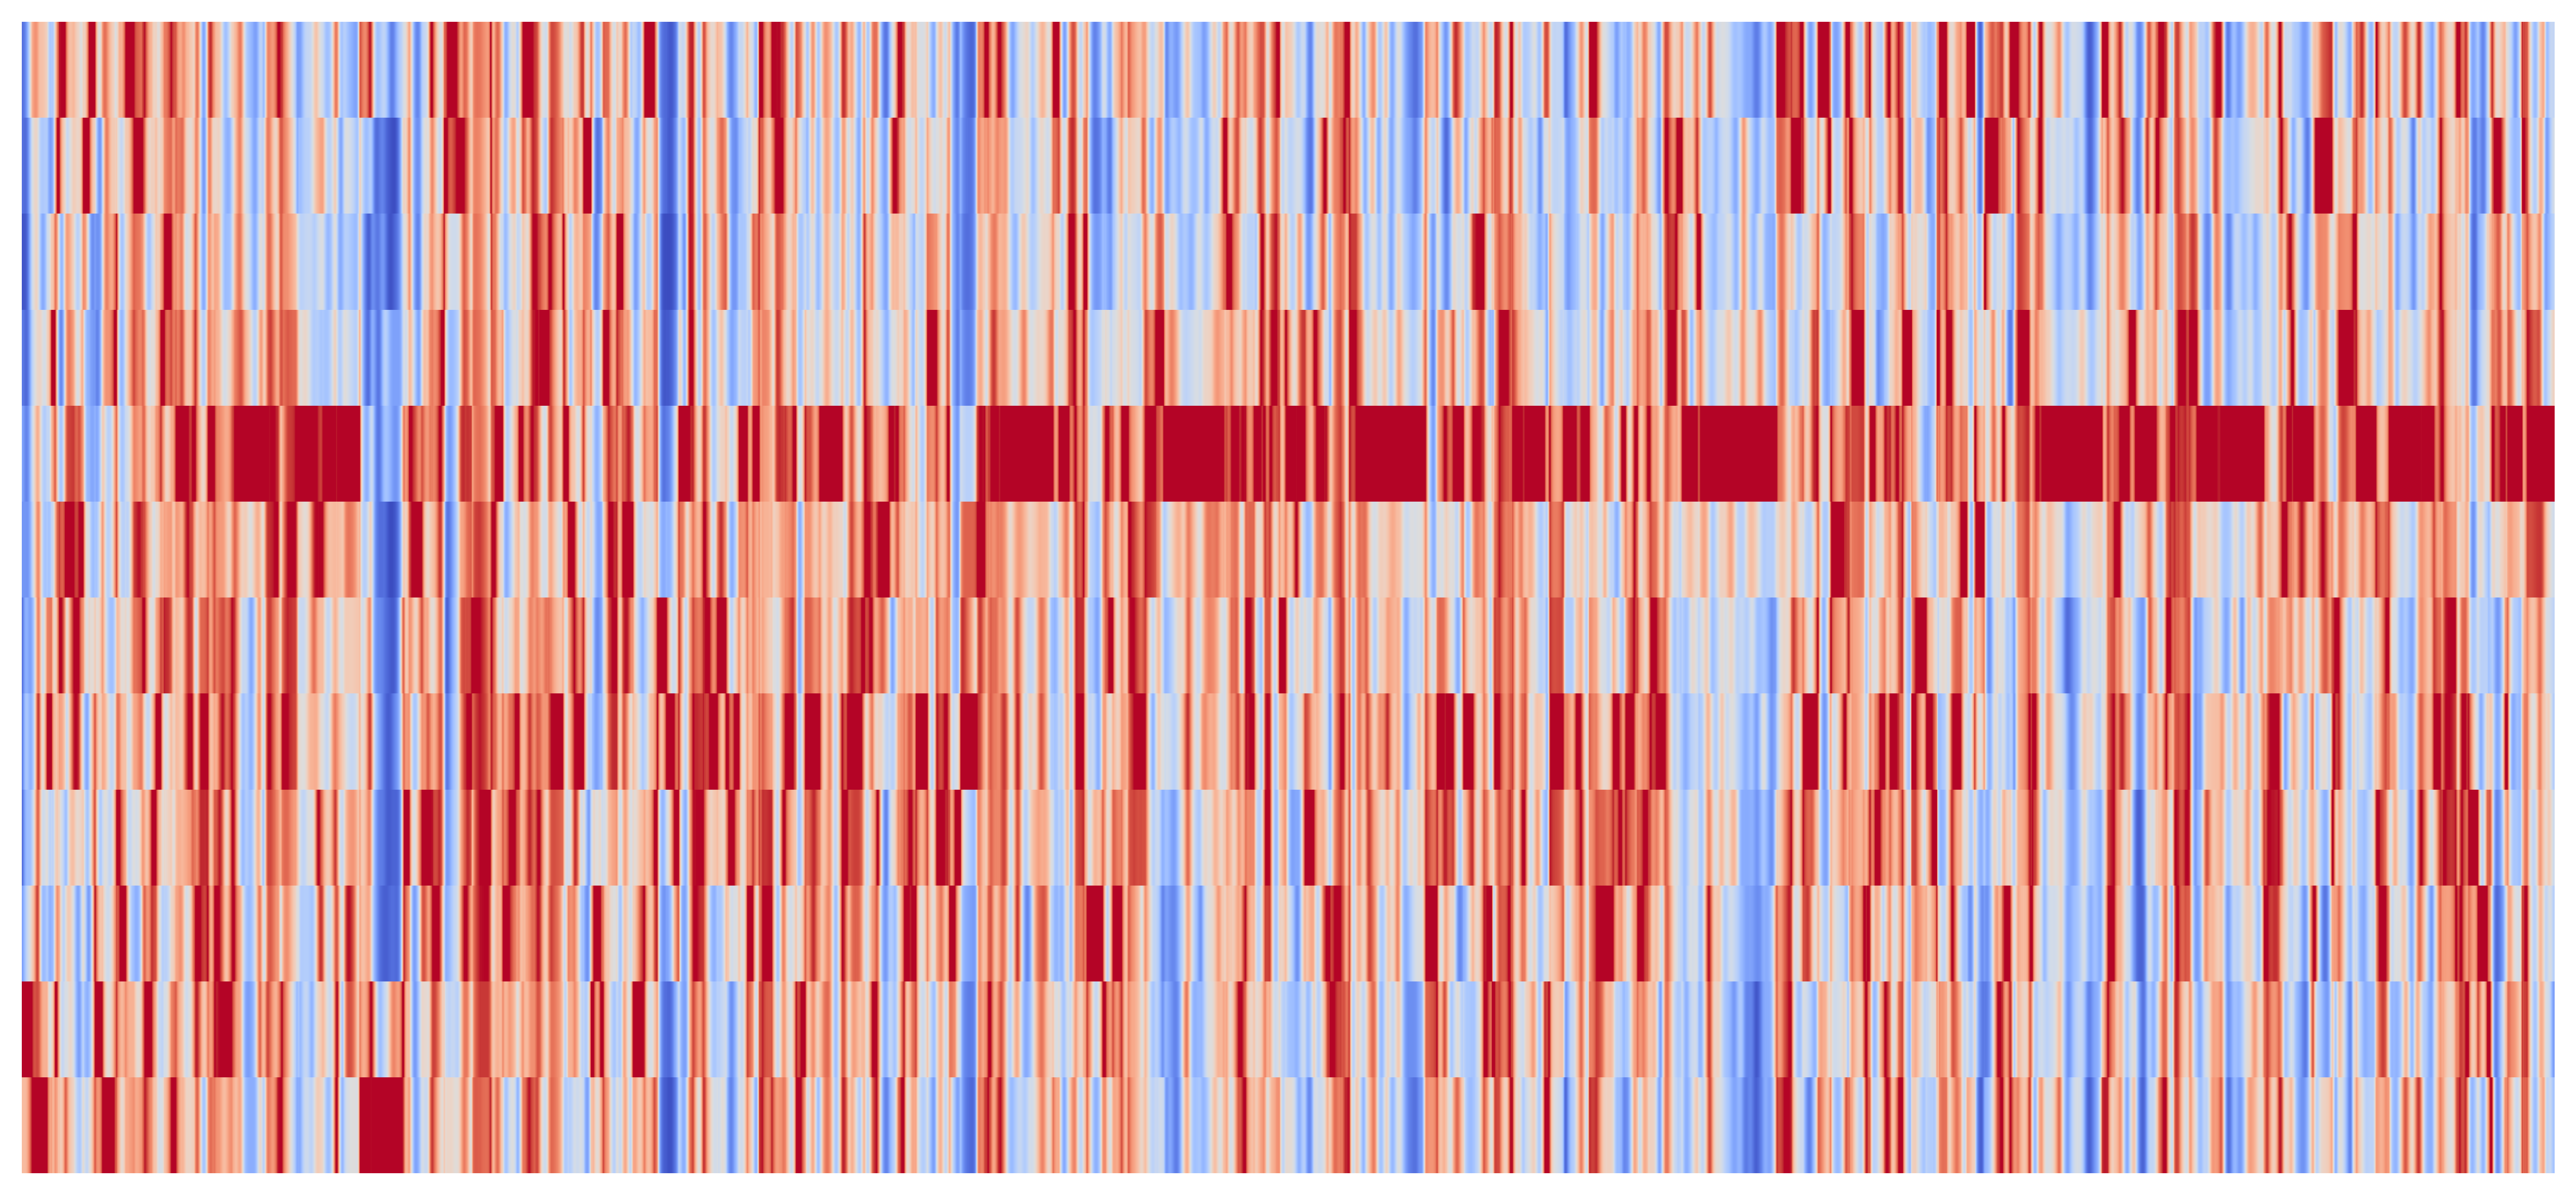

In [121]:
chromagram = librosa.feature.chroma_stft(x_out[13], sr=sr_out[13], hop_length=8)
plt.figure(figsize=(15, 7), dpi = 500)
plt.axis('off')
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=8, cmap='coolwarm');